In [1]:
#Import and extract data from TSA website
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tsawebsite = 'https://www.tsa.gov/coronavirus/passenger-throughput'

# Read data from TSA Website
webpage = Request(tsawebsite, headers={'User-Agent': 'Mozilla/5.0 Chrome/28.0.1464.0'})
sauce = str(urlopen(webpage).read())
sauce = sauce.encode('utf-8', 'ignore').decode('utf-8')
soup = BeautifulSoup(sauce,'html.parser')

# Parse data looking for relevant table
data = soup.find('table')
data = data.find_all('td')
data = [element.get_text() for element in data]
data = data[3:]

# Isolate the 3 relevant columns of the table
dates = data[0::3]
now = [int(element.replace(',','')) for element in data[1::3]]
before = [int(element.replace(',','')) for element in data[2::3]]

# Make variables for results
today = now[0]


In [2]:
#Make data into dataframe
dates_dt = [dt.datetime.strptime(date, '%m/%d/%Y') for date in dates]
dates_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
dates_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

base_data = pd.DataFrame({
    'Weekday':[dates_dict[date.weekday()] for date in dates_dt],
    'Now':now,
    'Before':before
},index=dates_dt)

base_data = base_data.sort_index(ascending=True)

base_data['rollwkavg'] = base_data['Now'].rolling(7,min_periods=7).mean()
base_data['rollmonthavg'] = base_data['Now'].rolling(30,min_periods=30).mean()
base_data['priorrollwkavg'] = base_data['Before'].rolling(7,min_periods=7).mean()

dataset_len = len(base_data['Now'])

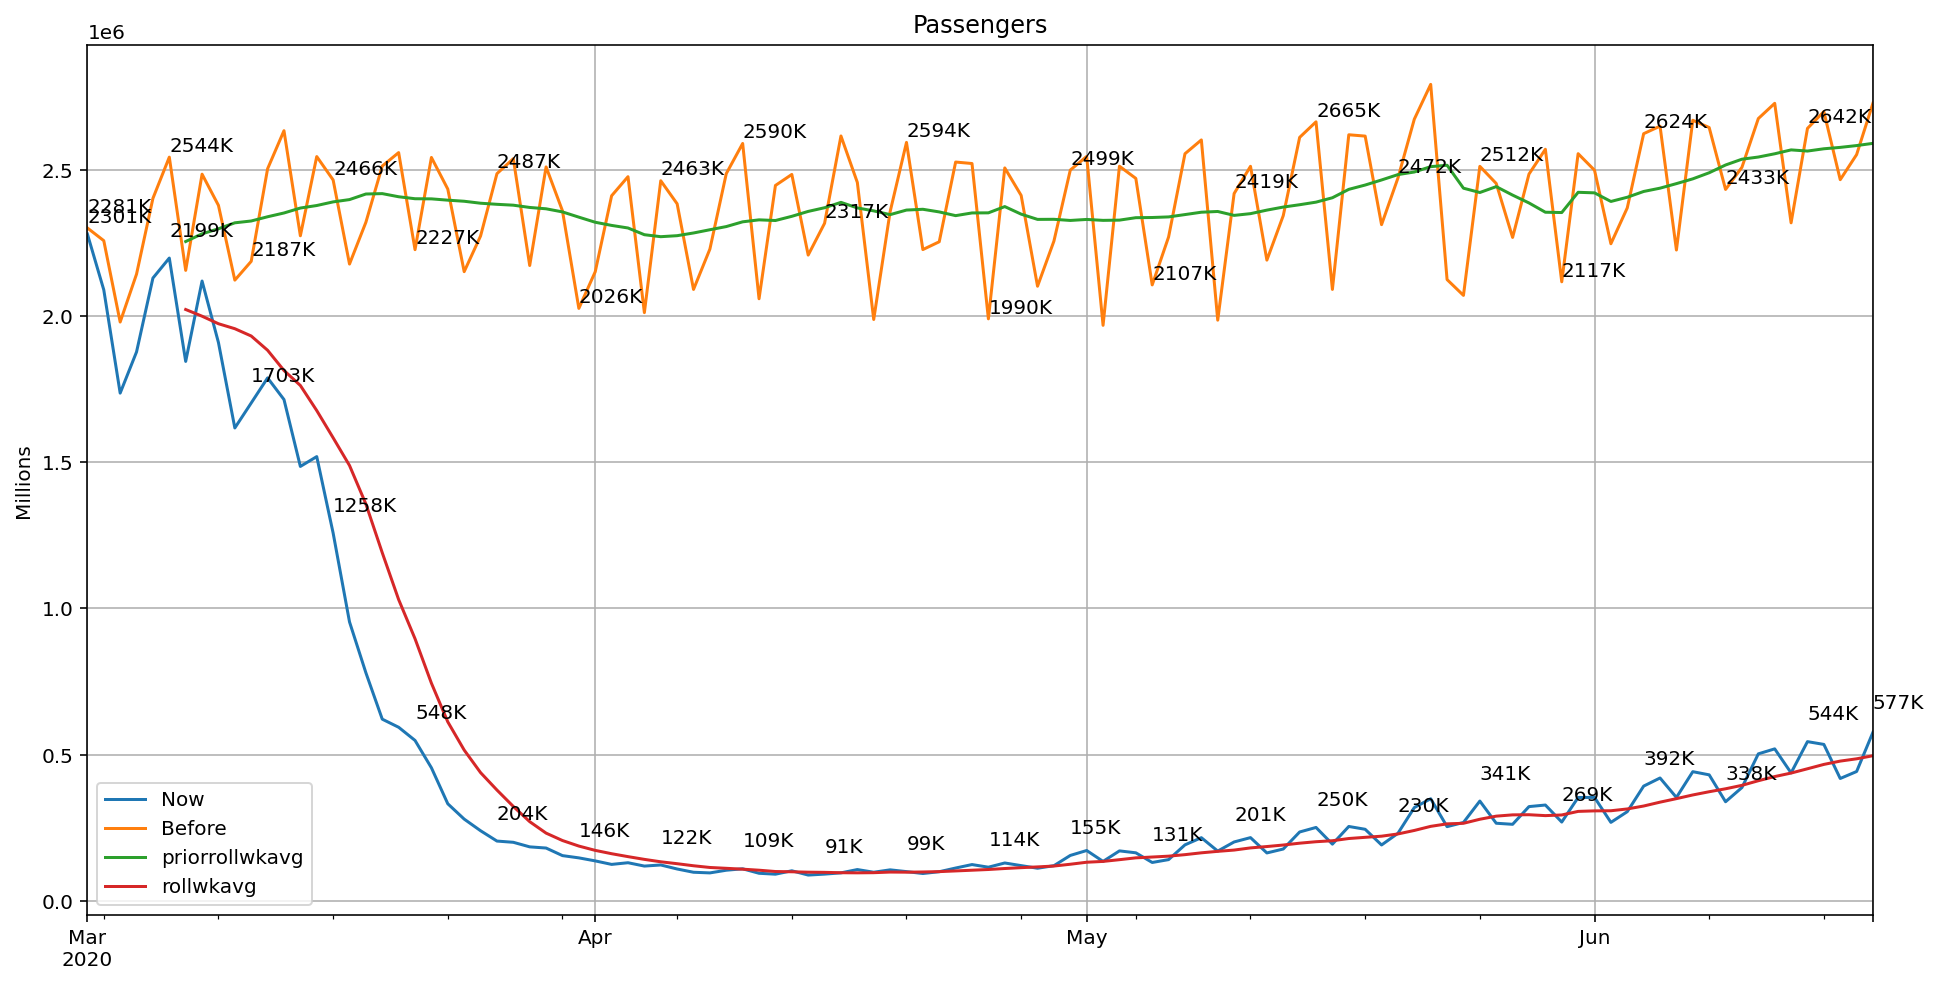

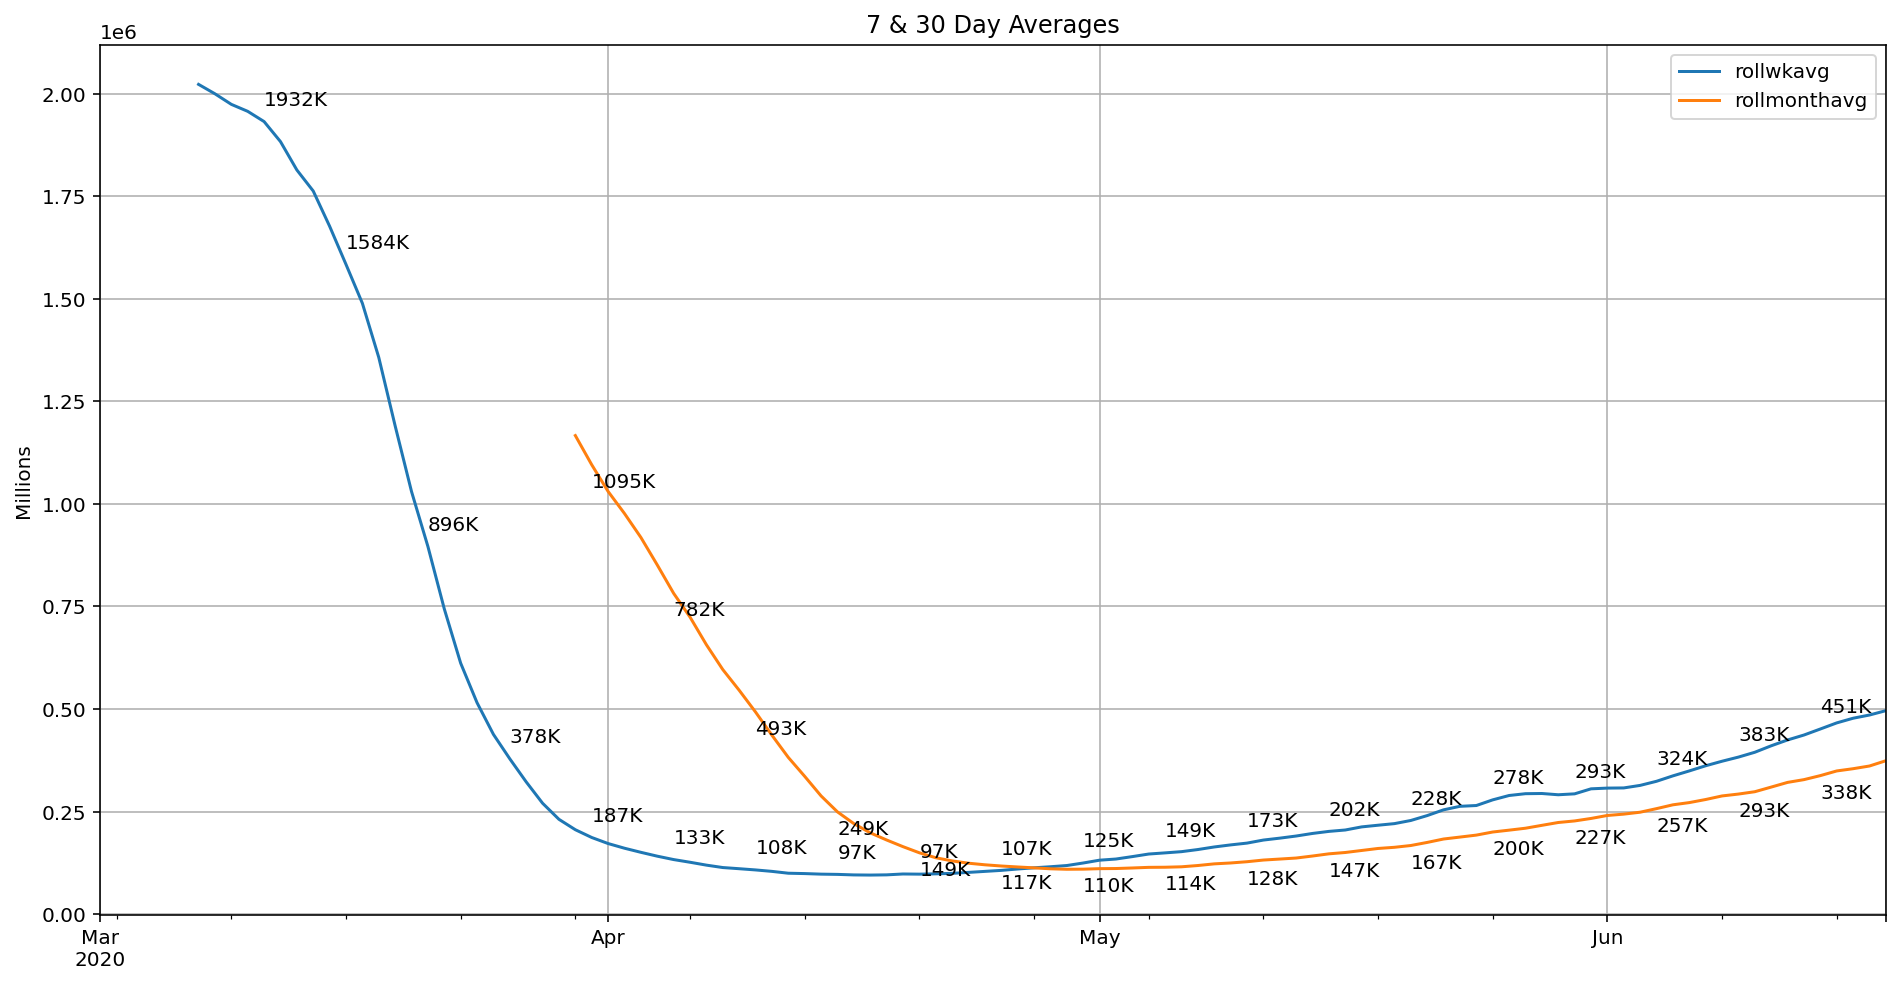

In [3]:
#Daily passenger and 7/30 day average plots
passengerplot = base_data.plot.line(y=['Now','Before','priorrollwkavg','rollwkavg'], figsize=(16,8), grid=True, title='Passengers')
passengerplot.set_ylabel("Millions")

for i in range(0,dataset_len,5):
    passnow=base_data['Now'][i]
    passbefore=base_data['Before'][i]

    passengerplot.annotate("{:.0f}{}".format(passnow/1000,'K'),(base_data.index[i],passnow+75000))
    passengerplot.annotate("{:.0f}{}".format(passbefore/1000,'K'),(base_data.index[i],passbefore+20000))
    
last_day_pass = base_data['Now'][dataset_len-1]
passengerplot.annotate("{:.0f}{}".format(last_day_pass/1000,'K'),(base_data.index[dataset_len-1],last_day_pass+80000))

#----------
averagesplot = base_data.plot.line(y=['rollwkavg','rollmonthavg'], figsize=(16,8), grid=True, title='7 & 30 Day Averages')
averagesplot.set_ylabel("Millions")

for i in range(0,dataset_len,5):
    weekavg = base_data['rollwkavg'][i]
    monthavg= base_data['rollmonthavg'][i]

    averagesplot.annotate("{:.0f}{}".format(weekavg/1000,'K'),(base_data.index[i],weekavg+40000))
    averagesplot.annotate("{:.0f}{}".format(monthavg/1000,'K'),(base_data.index[i],monthavg-55000))


Text(2020-06-18 00:00:00, 24.127123929835463, '21.1%')

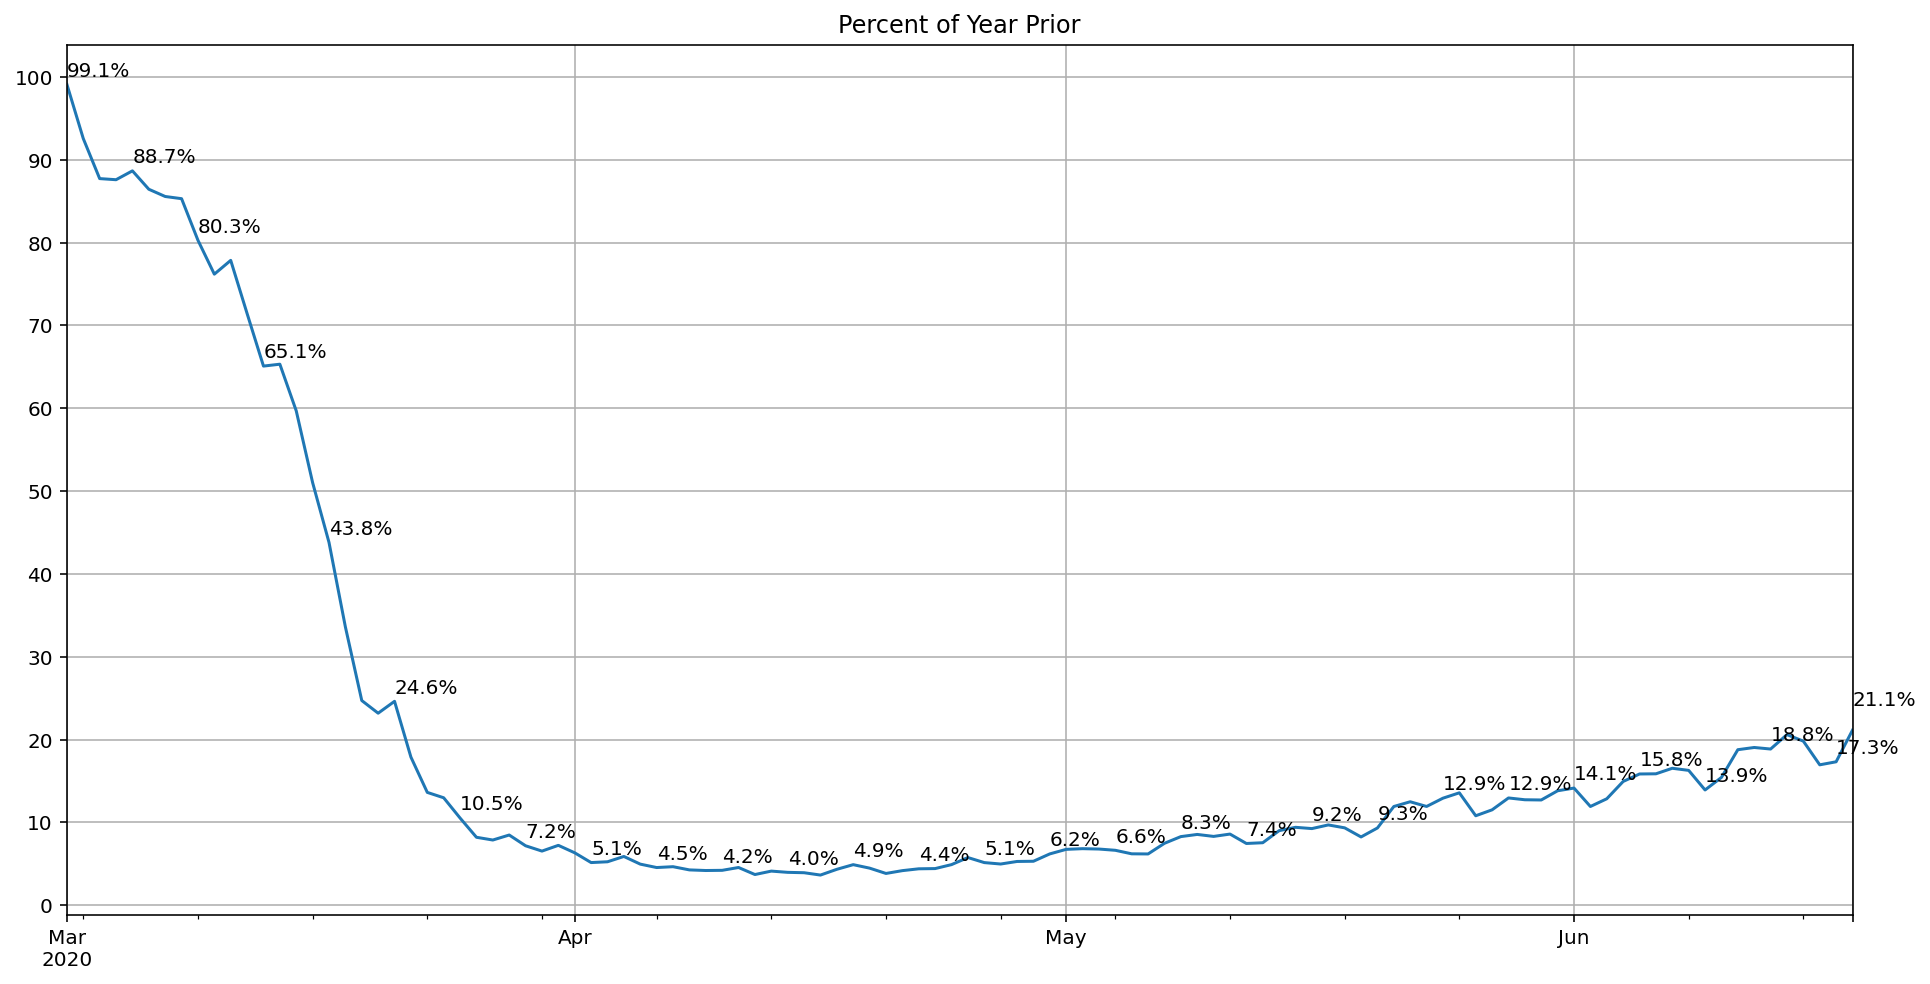

In [4]:
#Percentage of last year plot
pctlastyear = ((base_data['Now']/base_data['Before'])*100)
percentplot = pctlastyear.plot.line(figsize=(16,8), grid=True, title='Percent of Year Prior',yticks=range(0,110,10))

for x in range(0,dataset_len,4):
    percentplot.annotate("{:.1%}".format(pctlastyear[x]/100),(pctlastyear.index[x],pctlastyear[x]+1))
last_day_pct = pctlastyear[len(pctlastyear)-1]
percentplot.annotate("{:.1%}".format(last_day_pct/100),(pctlastyear.index[len(pctlastyear)-1],last_day_pct+3))

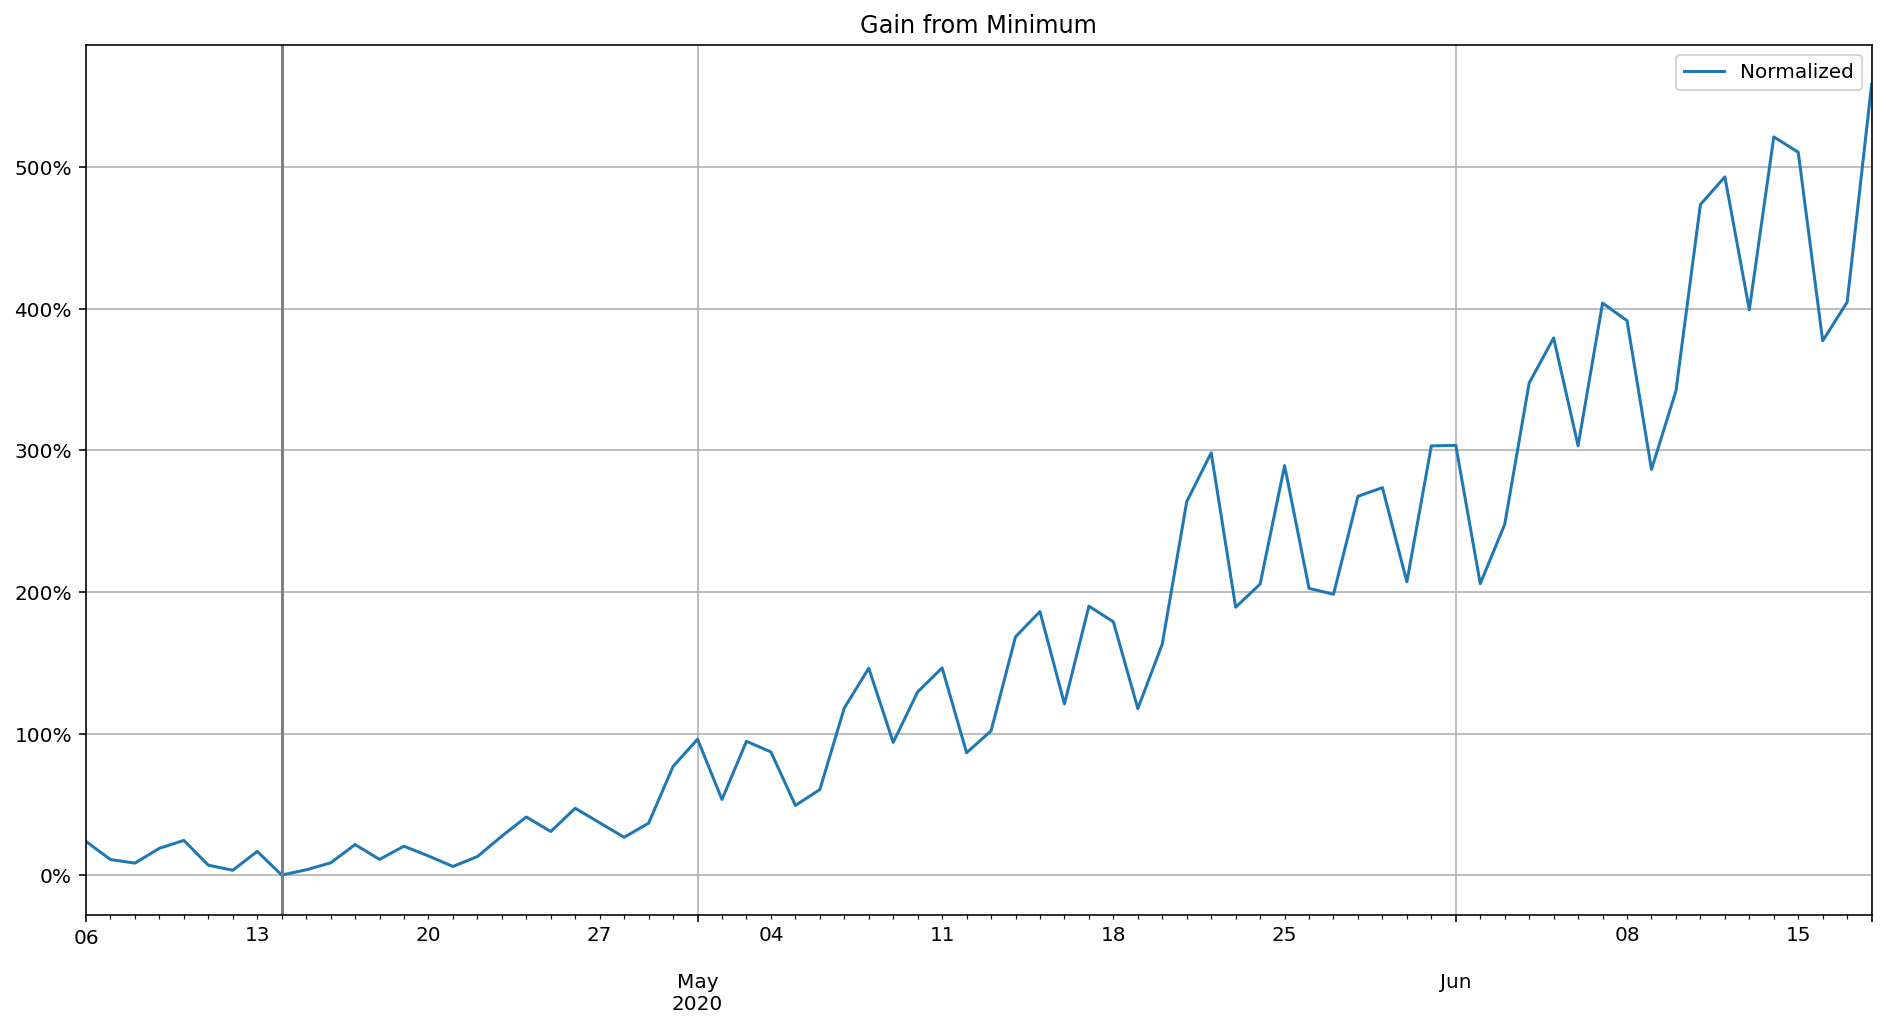

In [5]:
# graph to and from bottomd
basemin = int(base_data[['Now']].min())

mintomax =base_data[36:][['Now']]
mintomax['Normalized'] = ((mintomax['Now']/basemin)-1)*100

mintomaxplot = mintomax.plot.line(y='Normalized',figsize=(16,8), grid=True, title='Gain from Minimum')
mintomaxplot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
mintomaxplot.axvline(mintomax['Now'].idxmin(), color='gray')


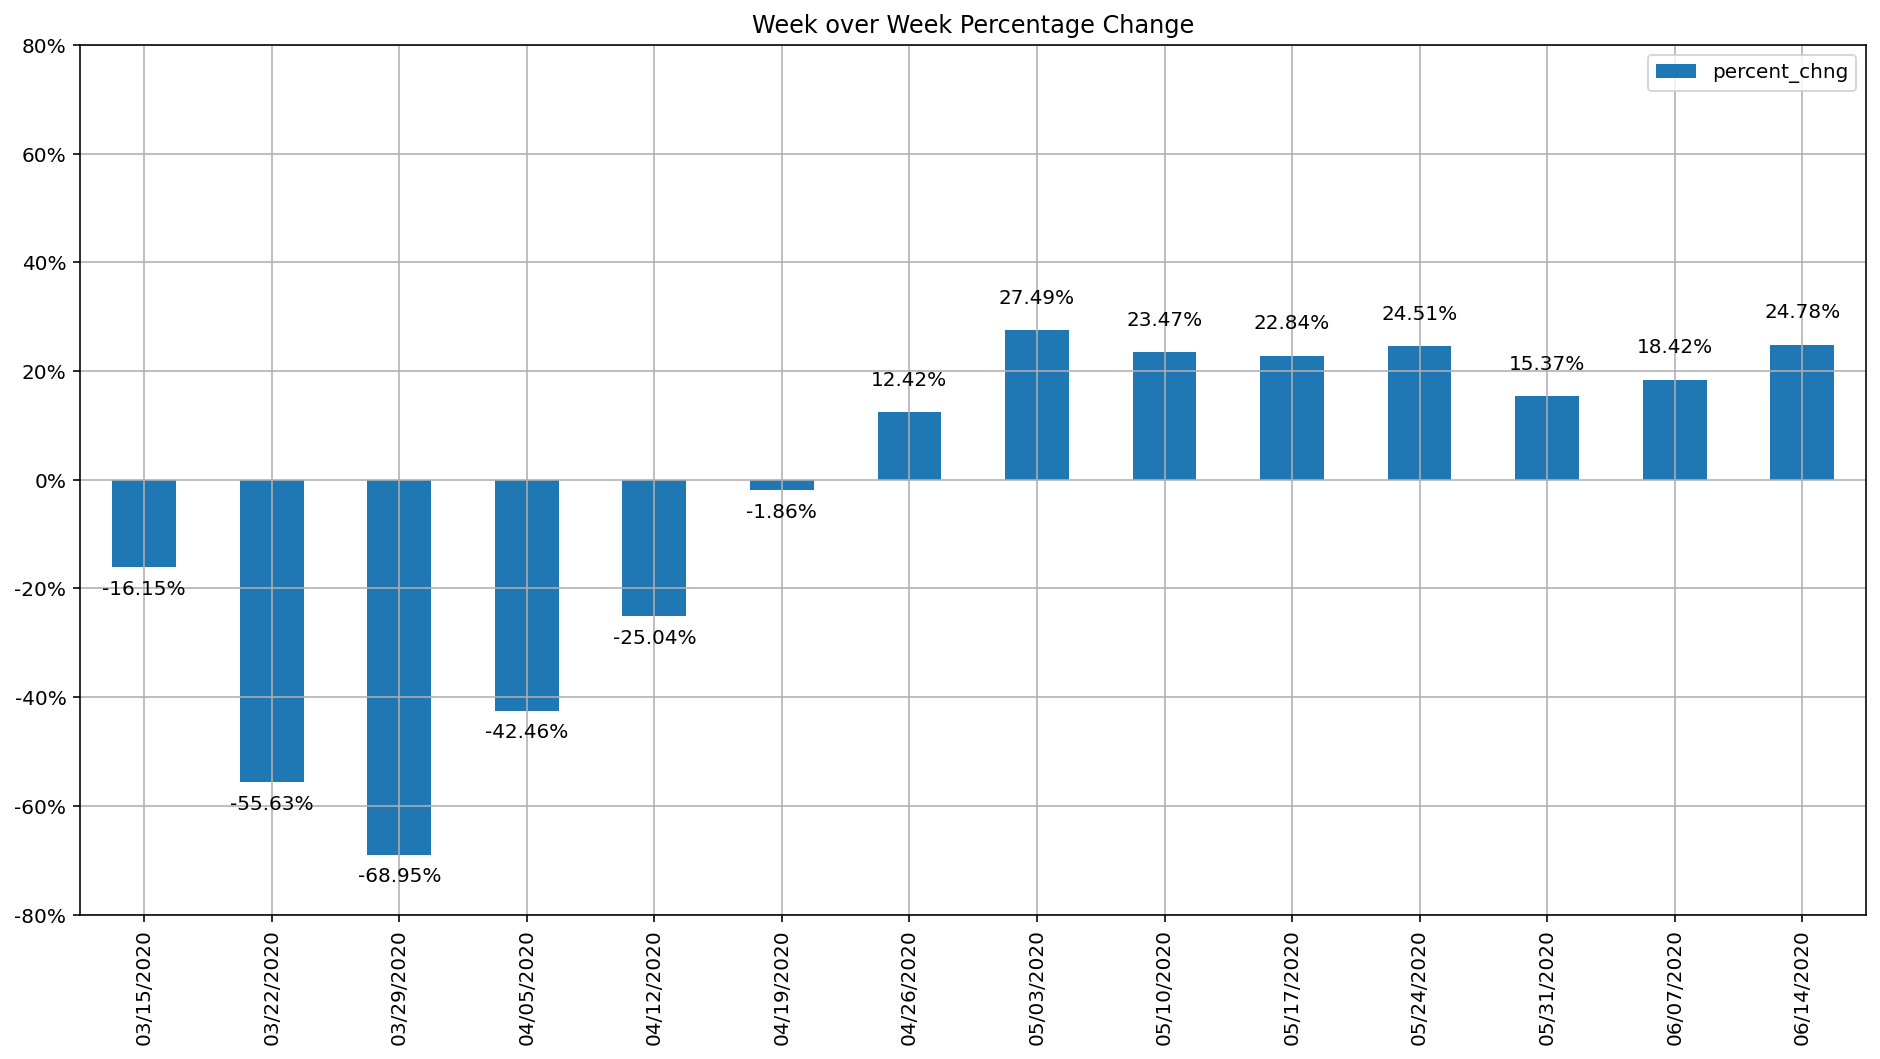

In [6]:
weeklyagg = base_data.resample('W').sum()
weeklyagg.drop(['rollwkavg','rollmonthavg'],axis=1,inplace=True)
weeklyagg = weeklyagg[1:]
weeklyagg['percent_chng'] = (weeklyagg['Now'].pct_change())*100
weeklyagg.index = [pd.to_datetime(str(date)).strftime('%m/%d/%Y') for date in weeklyagg.index]

weeklychngplot = weeklyagg[1:-1].plot.bar(y='percent_chng',figsize=(16,8), grid=True, title='Week over Week Percentage Change',ylim=(-80,80))
weeklychngplot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

i=0
for x in weeklyagg[1:-1]['percent_chng']:
    weeklychngplot.annotate(str(round(x,2))+'%',(i,x+5 if x>0 else x-5),ha='center')
    i+=1


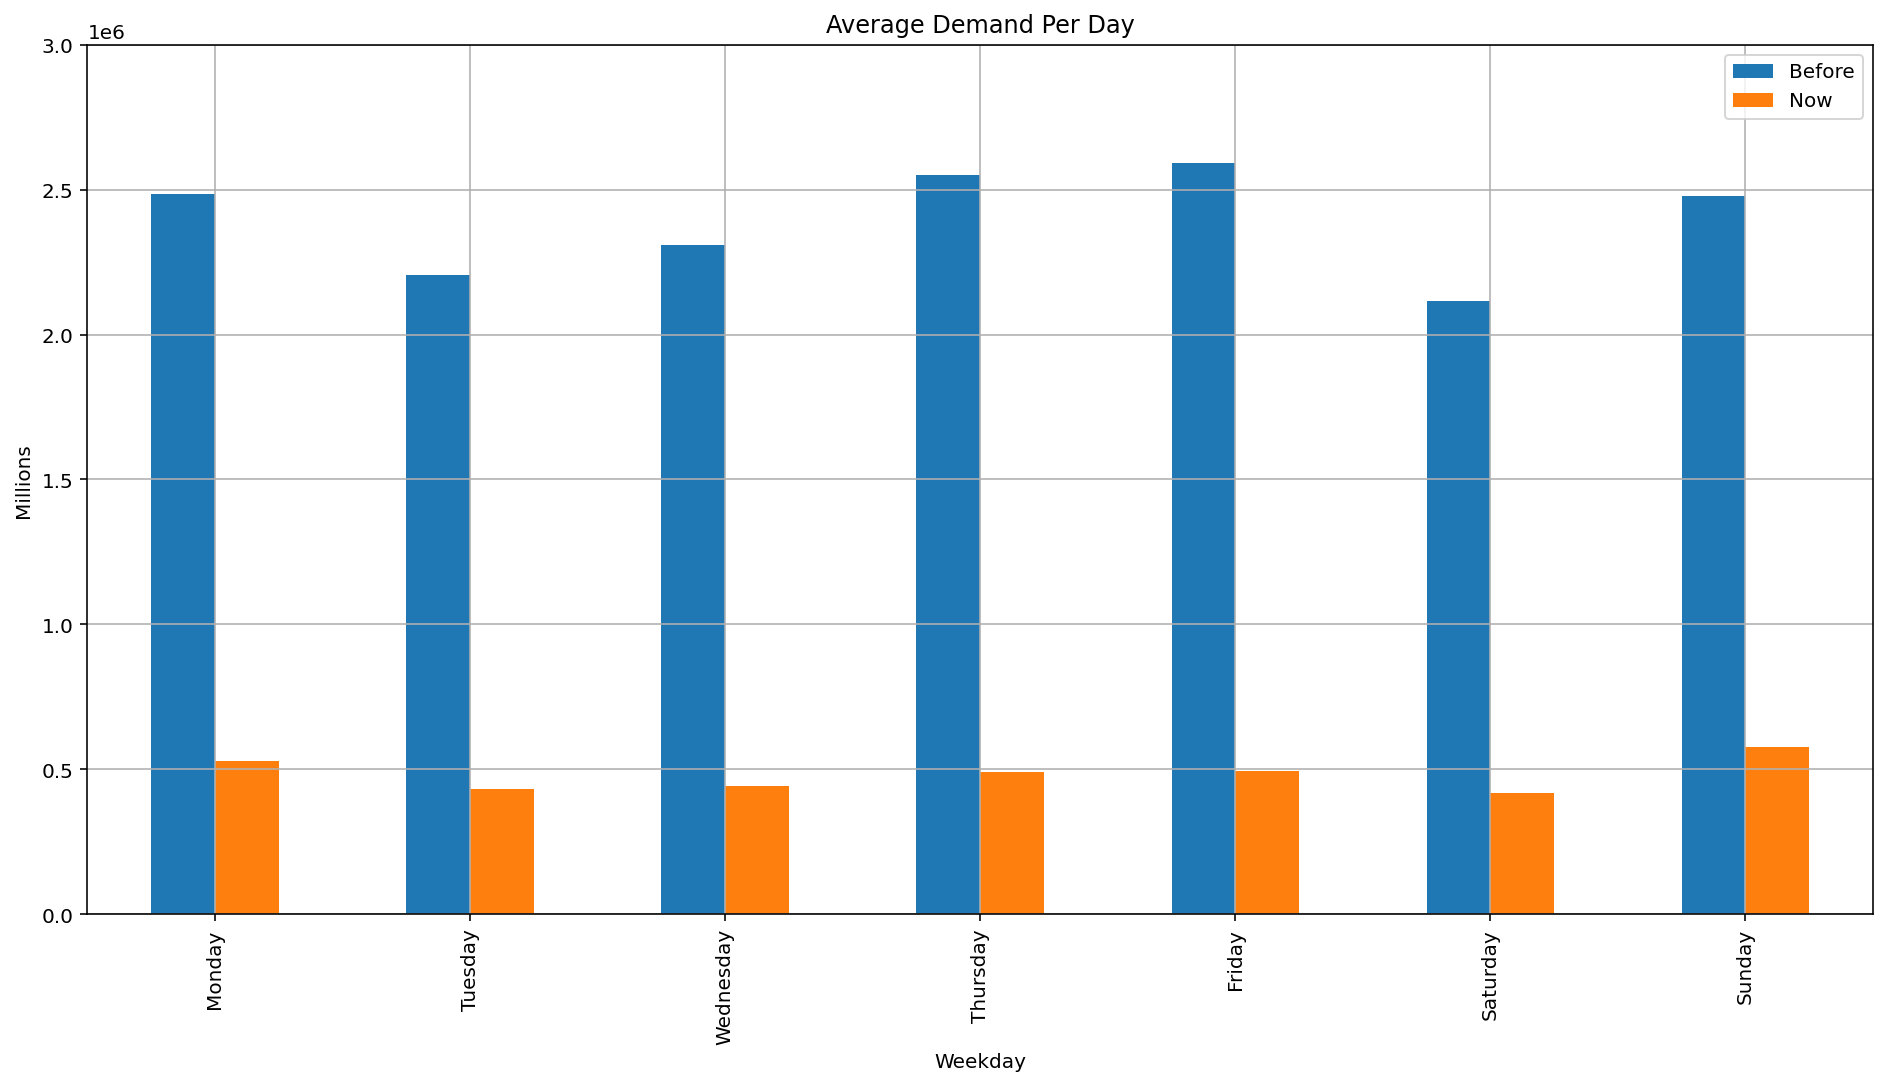

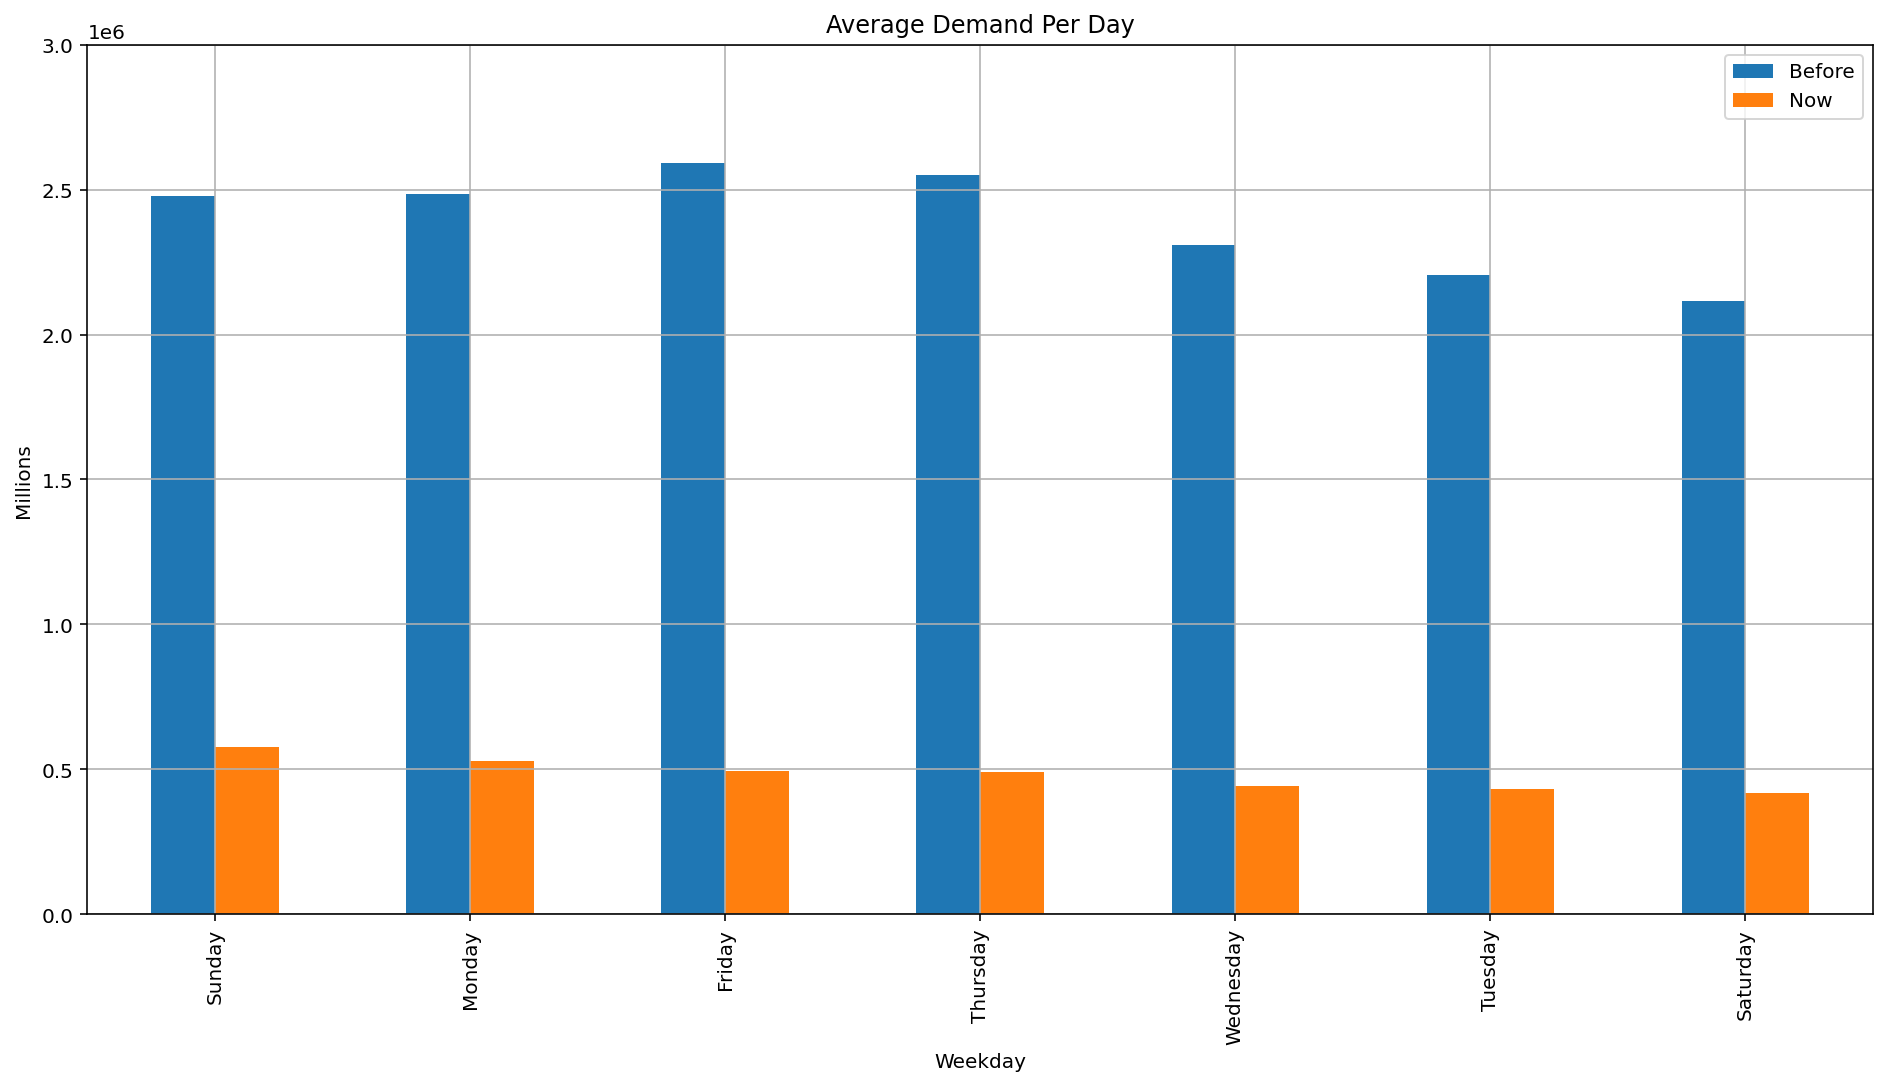

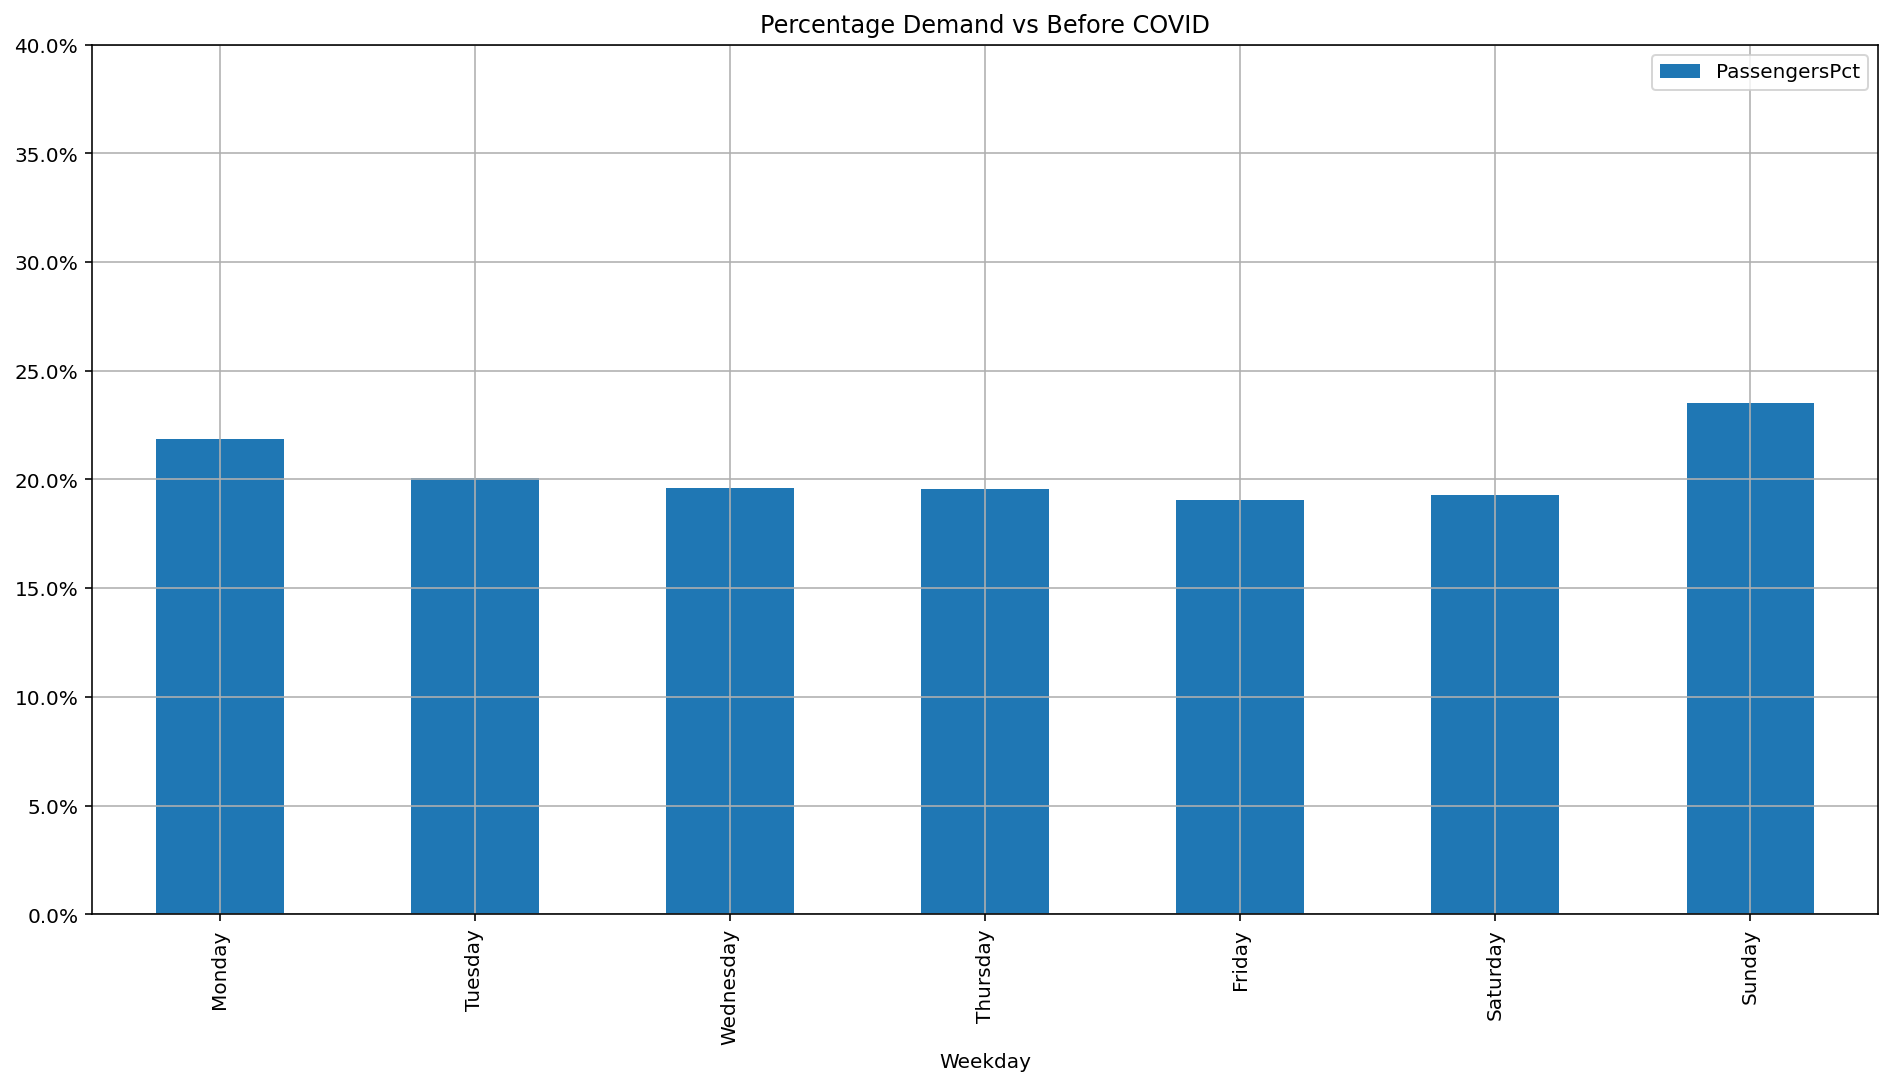

In [7]:
# Average per weekday plots
avgperweekday = base_data.groupby('Weekday').mean()
avgperweekday = avgperweekday.reindex(dates_dict.values())
weekdayplot = avgperweekday.plot.bar(y=['Before','Now'],grid=True,figsize=(16,8),ylim=(0,3000000), title='Average Demand Per Day')
weekdayplot.set_ylabel("Millions")

weekdaysort = avgperweekday.sort_values(ascending=False,by='Now')
weeksortplot = weekdaysort.plot.bar(y=['Before','Now'],grid=True,figsize=(16,8),ylim=(0,3000000), title='Average Demand Per Day')
weeksortplot.set_ylabel("Millions")


pctperweekday =pd.DataFrame({
    'PassengersPct':base_data['Now']/base_data['Before'],
    'Weekday':base_data['Weekday']
})
pctperweekday.set_index('Weekday',inplace=True)
pctweekdaydata = (pctperweekday.groupby(pctperweekday.index).mean())*100
pctweekdaydata['Order'] = [dates_list.index(x) for x in pctweekdaydata.index]
pctweekdaydata.sort_values('Order',inplace=True)
pctweekdayplot = pctweekdaydata.plot.bar(y='PassengersPct',grid=True,figsize=(16,8), ylim=(0,40), title='Percentage Demand vs Before COVID')
pctweekdayplot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())




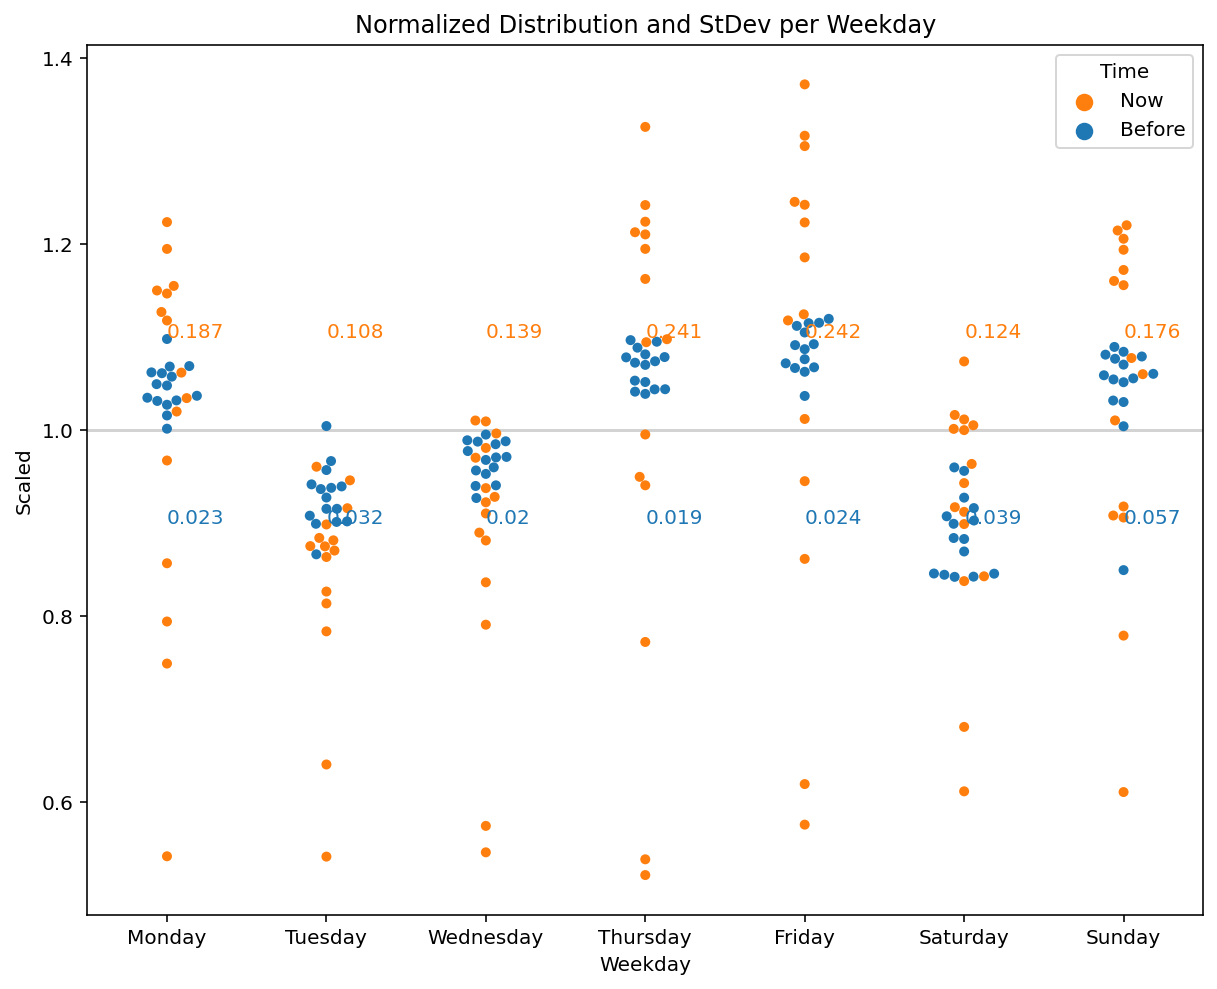

In [8]:
# Distribution and StDev plots
passengerdist = base_data[['Before','Weekday','Now']]
passengerdist['ScalePrior'] = passengerdist['Before']/base_data['priorrollwkavg']
passengerdist['ScaleNew'] = passengerdist['Now']/base_data['rollwkavg']
passengerdist.set_index('Weekday', inplace=True)
passengerdist = passengerdist[6:]

passengertotal = pd.DataFrame({
    'Passengers':pd.concat([passengerdist['Before'], passengerdist['Now']], axis=0),
    'Scaled':pd.concat([passengerdist['ScalePrior'], passengerdist['ScaleNew']], axis=0),
    'Time': ['Before']*len(passengerdist)+['Now']*len(passengerdist)
})
passengertotal['Order'] = [dates_list.index(x) for x in passengertotal.index]
passengertotal.sort_values('Order',inplace=True)

plt.figure(figsize = (10,8))
distributionplot = sns.swarmplot(x=passengertotal.index, y=passengertotal['Scaled'], data=passengertotal, hue='Time', palette=dict(Now = 'tab:orange', Before = 'tab:blue'))
distributionplot.set_title('Normalized Distribution and StDev per Weekday')

for i,element in enumerate(dates_list):
    priorstddata = passengerdist.loc[element]['ScalePrior'].values.tolist()
    priorstd = round(np.std(priorstddata),3)
    newstddata = passengerdist.loc[element]['ScaleNew'].values.tolist()
    newstd = round(np.std(newstddata),3)

    distributionplot.annotate(newstd,(i,1.1),color='tab:orange')
    distributionplot.annotate(priorstd,(i,0.9),color='tab:blue')
distributionplot.axhline(1, color='lightgray')

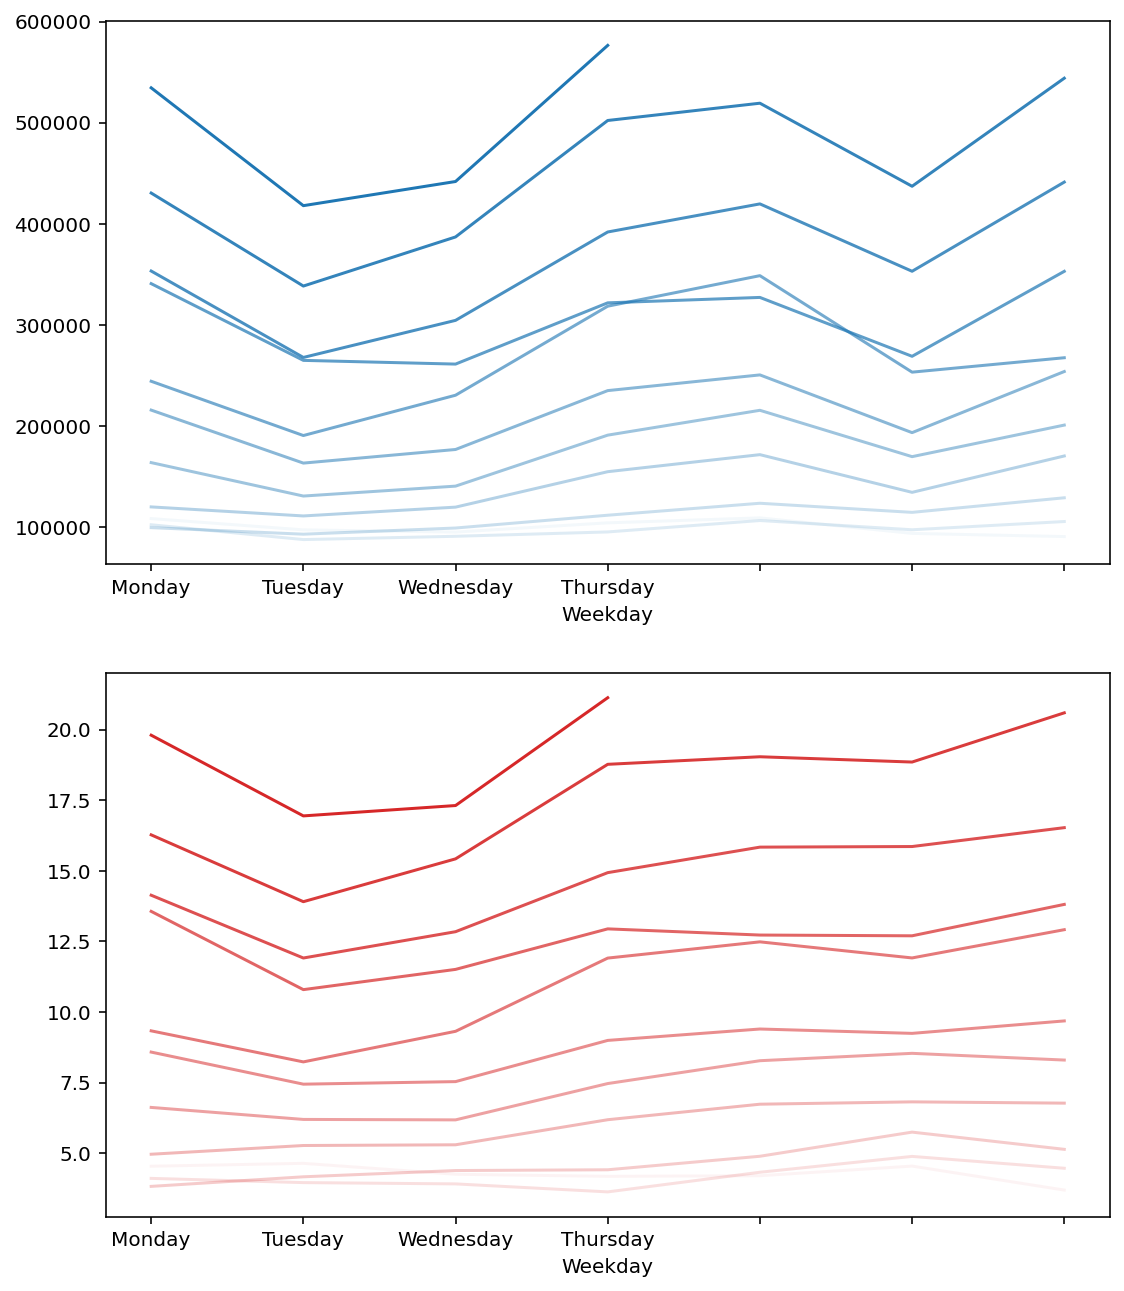

In [24]:
# Line graph of passengers per week. Stronger colors mean more recent.
weekline = base_data[36:][['Weekday','Now']]
weekline['Percentage'] = pctlastyear
weekline.reset_index(inplace=True)
weekline.set_index('Weekday',inplace=True)
weekline.rename(columns={"index": "Dates"},inplace=True)
weekline['Dates'] = [pd.to_datetime(str(date)).strftime('%m/%d') for date in weekline['Dates']]

fig, ax = plt.subplots(nrows=2, ncols=1)

linealpha = np.linspace(0.05, 1, math.ceil(len(weekline)/7))
for number,x in enumerate(range(0,len(weekline),7)):
    weekline['Now'][x:x+7].plot(ax=ax[0],alpha=linealpha[number],color='tab:blue',figsize=(9,11))
    weekline['Percentage'][x:x+7].plot(ax=ax[1],alpha=linealpha[number],color='tab:red',figsize=(9,11))
    # ax[0].annotate(str(weekline['Dates'][x]),(6,weekline['Now'][x+6]),fontsize='x-small')
#     ax[1].annotate(str(weekline['Dates'][x]),(6,weekline['Percentage'][x+6]),fontsize='x-small')

# ax[0].set_xticklabels(dates_list)
# ax[0].set_title('Daily Passengers per Day')
# ax[1].set_title('Percentage Passengers per Day')
# ax[1].yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
